<a href="https://colab.research.google.com/github/developer22-university/code_work12/blob/main/cyclegan_monet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import shutil
import time
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from skimage.exposure import match_histograms
from skimage import io

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Seed

In [ ]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(719)

# Get Image Data and SCRNN for preprocessing

In [ ]:
!gdown https://drive.google.com/uc?id=1INooyLws0tPJhBYs7pq9-wdeKgnUOqQu
!gdown https://drive.google.com/uc?id=1TwOk6uUhXdIPV6bSuvnPUlJwtiSz5rN9
!gdown https://drive.google.com/uc?id=1tR1MHwt5zE6oJbfrNEkeFLeasFMAfuN3
!gdown https://drive.google.com/uc?id=18j3HbHW0MTQoPjp0iCTuBYRRbaC3BdA5
!gdown https://drive.google.com/uc?id=10qamfU0yvZoueX6r--ybegbMfro5wWgu
!gdown https://drive.google.com/uc?id=16UbP5NWr6HhL_KQRjjWZ0s_3d11UClGA

!gdown https://drive.google.com/uc?id=1-1vstT4a_sUK7E41R6YBQzHRagx35RqU

Downloading...
From: https://drive.google.com/uc?id=1INooyLws0tPJhBYs7pq9-wdeKgnUOqQu
To: /content/30_monet.zip
100% 501k/501k [00:00<00:00, 57.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TwOk6uUhXdIPV6bSuvnPUlJwtiSz5rN9
To: /content/photo_jpg.zip
100% 98.0M/98.0M [00:00<00:00, 165MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tR1MHwt5zE6oJbfrNEkeFLeasFMAfuN3
To: /content/monet_jpg.zip
100% 4.92M/4.92M [00:00<00:00, 61.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=18j3HbHW0MTQoPjp0iCTuBYRRbaC3BdA5
To: /content/srcnn_x2.pth
100% 230k/230k [00:00<00:00, 56.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=10qamfU0yvZoueX6r--ybegbMfro5wWgu
To: /content/monet_jpg_hd.zip
100% 1.42M/1.42M [00:00<00:00, 66.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=16UbP5NWr6HhL_KQRjjWZ0s_3d11UClGA
To: /content/monet_jpg0.zip
100% 3.66M/3.66M [00:00<00:00, 159MB/s]
Access denied with the following error:

 	Cannot retrieve the public link of th

In [ ]:
!mkdir /content/photo_jpg
!unzip -qq /content/photo_jpg.zip -d /content/photo_jpg
!mkdir /content/monet_jpg
!unzip -qq /content/monet_jpg.zip -d /content/monet_jpg
!mkdir /content/30_monet
!unzip -qq /content/30_monet.zip -d /content/30_monet
!mkdir /content/monet_jpg_hd
!unzip -qq /content/monet_jpg_hd.zip -d /content/monet_jpg_hd
!mkdir /content/monet_jpg0
!unzip -qq /content/monet_jpg0.zip -d /content/monet_jpg0

# Create 300 Monet pictures out of 30 selected Monet pictures

In [ ]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

def convert_rgb_to_ycbcr(img):
    y = 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
    cb = 128. + (-37.945 * img[:, :, 0] - 74.494 * img[:, :, 1] + 112.439 * img[:, :, 2]) / 256.
    cr = 128. + (112.439 * img[:, :, 0] - 94.154 * img[:, :, 1] - 18.285 * img[:, :, 2]) / 256.
    return np.array([y, cb, cr]).transpose([1, 2, 0])

def convert_ycbcr_to_rgb(img):
    r = 298.082 * img[:, :, 0] / 256. + 408.583 * img[:, :, 2] / 256. - 222.921
    g = 298.082 * img[:, :, 0] / 256. - 100.291 * img[:, :, 1] / 256. - 208.120 * img[:, :, 2] / 256. + 135.576
    b = 298.082 * img[:, :, 0] / 256. + 516.412 * img[:, :, 1] / 256. - 276.836
    return np.array([r, g, b]).transpose([1, 2, 0])


def create_300_monet_pics():
    src_dir = '/content/monet_jpg0/'
    tmp_dir =  '/content/monet_jpg_hd/'
    dst_dir = '/content/monet_300_jpg/'

    !mkdir -p dst_dir
    !mkdir -p tmp_dir

    # the subset of 30 Monet pictures that were selected as described in the project report
    pics30 = [
            '011835cfbf.jpg', '05144e306f.jpg', '1f9667f2a7.jpg', '2c00f5147f.jpg', '3c341ff93e.jpg', '3eaef3ee43.jpg', 
            '4ab2583fe2.jpg', '5185e8c56a.jpg', '586acab7c5.jpg', '5cb895b722.jpg', '5ffbfe68d4.jpg', '676a5a4c2e.jpg', 
            '68729aac07.jpg', '718445ebe3.jpg', '7960adbd50.jpg', '8314acfd35.jpg', '8e5ff15568.jpg', '932d0dd808.jpg', 
            'a642e9cb6f.jpg', 'a7977705be.jpg', 'b13c0973ee.jpg', 'ce3e0daddd.jpg', 'd1d9748a64.jpg', 'd729785cb8.jpg', 
            'd88482796d.jpg', 'e568f84fad.jpg', 'f4413e97bd.jpg', 'fb806a2a1c.jpg', 'fd63a333f1.jpg', 'ffd74c77ea.jpg'
    ]

    # Copy 30 selected Modet pictures to destination dir
    for monet_file_name in pics30:
        src_path = os.path.join(src_dir, monet_file_name)
        dst_path = os.path.join(dst_dir, monet_file_name)
        shutil.copyfile(src_path, dst_path)

    # Super Resolution photos 256x256 --> 512x512 pixels
    model = SRCNN().to(device)
    state_dict = model.state_dict()
    for n, p in torch.load('/content/srcnn_x2.pth', map_location=lambda storage, loc: storage).items():
        if n in state_dict.keys():
            state_dict[n].copy_(p)
        else:
            raise KeyError(n)
    a= model.eval()

    for monet_file_name in pics30:
        monet_jpg_path = os.path.join(src_dir, monet_file_name)
        img = Image.open(monet_jpg_path).convert('RGB')
        img = img.resize((512, 512), resample=Image.BICUBIC)
        img = np.array(img).astype(np.float32)
        ycbcr = convert_rgb_to_ycbcr(img)
        y = ycbcr[..., 0]
        y /= 255.
        y = torch.from_numpy(y).to(device)
        y = y.unsqueeze(0).unsqueeze(0)

        with torch.no_grad():
            preds = model(y).clamp(0.0, 1.0)
        preds = preds.mul(255.0).cpu().numpy().squeeze(0).squeeze(0)

        output = np.array([preds, ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
        output = np.clip(convert_ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)
        output = Image.fromarray(output)

        monet_jpg_hd_path = os.path.join(tmp_dir, monet_file_name.replace('.', '-HD.'))
        output.save(monet_jpg_hd_path)

    #Cropping each 512x512 picture, into  five 256x256 pictures
    images_list = os.listdir(tmp_dir)
    crops = {
        '0':[0, 0],
        '1':[0, 256],
        '2':[256,0],
        '3':[256, 256],
        '4':[128, 128]
    }

    for image_fname in images_list:
        image_src_fname = tmp_dir + image_fname
        image_src = io.imread(image_src_fname)
        
        for crop, [r0, c0] in crops.items():
            image_dst_fname = dst_dir + image_fname[:-4] + crop + '.jpg'
            image_dest = image_src[r0:r0+256, c0:c0+256]
            io.imsave(image_dst_fname, image_dest)

    #Creating images in Monet's favourite colors using colors matching histograms
    ref_colors = {
        '-B':'1f9667f2a7.jpg',
        '-C':'3c341ff93e.jpg',
        '-R':'05144e306f.jpg',
        '-W':'68729aac07.jpg'
        }

    for image_fname in pics30:
        image_src_fname = src_dir + image_fname
        image_src = io.imread(image_src_fname)

        for color, color_fname in ref_colors.items():
            image_ref_fname = src_dir + color_fname
            image_ref = io.imread(image_ref_fname)
            image_dst_fname = dst_dir + image_fname[:-4] + color + '.jpg'
            image_dest = match_histograms(image_src, image_ref, multichannel=True)
            io.imsave(image_dst_fname, image_dest)

# Dataset and Dataloader

In [ ]:
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
        
    return img

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir):
        super().__init__()
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.monet_idx = dict()
        self.photo_idx = dict()

        self.transform_P = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
        ])

        for i, fl in enumerate(os.listdir(self.monet_dir)):
            self.monet_idx[i] = fl
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        rand_idx_P = int(np.random.uniform(0, len(self.photo_idx.keys())))
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx_P])
        rand_idx_M = int(np.random.uniform(0, len(self.monet_idx.keys())))
        monet_path = os.path.join(self.monet_dir, self.monet_idx[rand_idx_M])
        real_P = Image.open(photo_path)
        real_P = self.transform_P(real_P)
        real_M = Image.open(monet_path)

        real_M = transforms.ToTensor()(real_M)
        real_M = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(real_M)
        return real_P, real_M

    def __len__(self):
        return min(len(self.monet_idx.keys()), len(self.photo_idx.keys()))

In [ ]:
img_ds = ImageDataset('/content/monet_jpg/', '/content/photo_jpg/') # TODO monet_jpg_old?
img_dl = DataLoader(img_ds, batch_size=1, pin_memory=True)

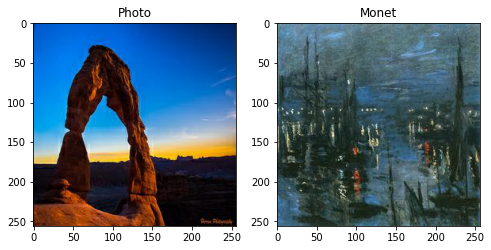

In [ ]:
real_P, real_M = next(iter(img_dl))

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.title('Photo')
real_P = unnorm(real_P)
plt.imshow(real_P[0].permute(1, 2, 0))
f.add_subplot(1, 2, 2)
plt.title('Monet')
real_M = unnorm(real_M)
plt.imshow(real_M[0].permute(1, 2, 0))

# Model

In [ ]:
class Resblock(nn.Module):
    def __init__(self):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(num_features=256))
        layers.append(nn.ReLU())

        layers.append(nn.Dropout(p=0.5))
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(num_features=256))
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)  # skip connection at end of Res block

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        model = list()
        model.append(nn.ReflectionPad2d(3))

        model.append(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=0, bias=True))
        model.append(nn.InstanceNorm2d(num_features=64))
        model.append(nn.ReLU())

        model.append(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True))
        model.append(nn.InstanceNorm2d(num_features=128))
        model.append(nn.ReLU())

        model.append(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=True))
        model.append(nn.InstanceNorm2d(num_features=256))
        model.append(nn.ReLU())

        for _ in range(9):      # 9 Res blocks  @@
            model.append(Resblock())

        model.append(nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1))
        model.append(nn.InstanceNorm2d(num_features=128))
        model.append(nn.Dropout(p=0.5))
        model.append(nn.ReLU())

        model.append(nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1))
        model.append(nn.InstanceNorm2d(num_features=64))
        model.append(nn.Dropout(p=0.5))
        model.append(nn.ReLU())

        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=0))
        model.append(nn.Tanh())

        self.gen = nn.Sequential(*model)

    def forward(self, x):
        return self.gen(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1))
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        model.append(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=1, padding=1, bias=True))
        model.append(nn.InstanceNorm2d(num_features=128))
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        model.append(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=1, padding=1, bias=True))
        model.append(nn.InstanceNorm2d(num_features=256))
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        model.append(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=True))
        model.append(nn.InstanceNorm2d(num_features=512))
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        model.append(nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1))
        self.disc = nn.Sequential(*model)

    def forward(self, x):
        return self.disc(x)

# Some additional classes and functions

In [ ]:
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [ ]:
# Save 50 generated fake images and sample through them
# to feed discriminators to avoid large oscillations 
# from iterations to iterations. (refer to CycleGAN orginal paper, section 4)
class ImagePool(object):
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        self.cur_image = 0
        self.pool = []

    def __call__(self, image):
        if self.cur_image < self.pool_size:
            self.pool.append(image)
            ret = image
            self.cur_image += 1
        else:
            if np.random.ranf() > 0.5:
                idx = np.random.randint(0, self.pool_size)
                ret = self.pool[idx]
                self.pool[idx] = image
            else:
                ret = image
        return ret

In [ ]:
class lr_sched():
    def __init__(self, n_epochs_decay , n_epochs):
        self.n_epochs_decay  = n_epochs_decay 
        self.n_epochs = n_epochs

    def step(self, epoch_num):
        if epoch_num <= self.n_epochs_decay :
            return 1.0
        else:
            fract = (epoch_num - self.n_epochs_decay )  / (self.n_epochs - self.n_epochs_decay)
            return 1.0 - fract

# GAN Class

In [ ]:
class CycleGAN(object):
    def __init__(self, device):
        self.n_epochs = 10
        self.n_epochs_decay = int(self.n_epochs/2)
        self.lambda_P = 10
        self.lambda_M = 10
        self.lambda_idt = 0.5
        self.start_lr = 2e-4
        self.device = device
        self.netG_M = Generator()
        self.netG_P = Generator()
        self.netD_M = Discriminator()
        self.netD_P = Discriminator()
        self.netG_M = self.netG_M.to(self.device)
        self.netG_P = self.netG_P.to(self.device)
        self.netD_M = self.netD_M.to(self.device)
        self.netD_P = self.netD_P.to(self.device)

        self.criterionGAN = nn.MSELoss()
        self.criterionCycle = nn.L1Loss()
        self.criterionIdt = nn.L1Loss()
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_M.parameters(), self.netG_P.parameters()),
                                         lr=self.start_lr, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_M.parameters(), self.netD_P.parameters()),
                                          lr=self.start_lr, betas=(0.5, 0.999))
        self.fake_M_pool = ImagePool()
        self.fake_P_pool = ImagePool()
        G_lr = lr_sched(self.n_epochs_decay , self.n_epochs)
        self.G_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.optimizer_G, G_lr.step)
        D_lr = lr_sched(self.n_epochs_decay , self.n_epochs)
        self.D_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.optimizer_D, D_lr.step)
        self.losses_G = []
        self.losses_D = []
        # list of 5 photos to be evaluated in epochs
        self.real_Ps = []
        for i in range(5):
            real_P, _ = next(iter(img_dl))
            self.real_Ps.append(real_P)
        
    def train(self, photo_dl, resume_file=None):
        if resume_file:
            print("=> loading checkpoint '{}'".format(resume_file))
            checkpoint = torch.load(resume_file)
            epoch_count = checkpoint['epoch']
            gan.netG_M.load_state_dict(checkpoint['netG_M'])
            gan.netG_P.load_state_dict(checkpoint['netG_P'])
            gan.netD_M.load_state_dict(checkpoint['netD_M'])
            gan.netD_P.load_state_dict(checkpoint['netD_P'])
            gan.optimizer_G.load_state_dict(checkpoint['optimizer_gen'])
            gan.optimizer_D.load_state_dict(checkpoint['optimizer_desc'])
            print("=> loaded checkpoint '{}' (epoch {})".format(resume_file, epoch_count))
        else:
            epoch_count = 0

        for epoch in range(epoch_count, self.n_epochs):
            epoch_start_time = time.time()
            avg_loss_G = 0.0
            avg_loss_D = 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            for i, (photo_real, monet_real) in enumerate(t):
                real_P, real_M = photo_real.to(device), monet_real.to(device)
                update_req_grad([self.netD_M, self.netD_P], False)
                self.optimizer_G.zero_grad()

                # Forward pass through generator
                fake_M = self.netG_P(real_P)  # G_P(P)
                rec_P = self.netG_M(fake_M)   # G_M(G_P(P))
                fake_P = self.netG_M(real_M)  # G_M(M)
                rec_M = self.netG_P(fake_P)   # G_P(G_M(M))

                # Backward: calculate the loss for generators G_P and G_M
                idt_P = self.netG_P(real_M)
                loss_idt_P = self.criterionIdt(idt_P, real_M) * self.lambda_M * self.lambda_idt
                idt_M = self.netG_M(real_P)
                loss_idt_M = self.criterionIdt(idt_M, real_P) * self.lambda_P * self.lambda_idt

                # generator losses - identity, Adversarial, cycle consistency
                
                loss_cycle_P = self.criterionCycle(rec_P, real_P) * self.lambda_P
                loss_cycle_M = self.criterionCycle(rec_M, real_M) * self.lambda_M
                
                netD_out_size = self.netD_M(fake_M).size() # netD output tensor size
                real = torch.ones(netD_out_size).to(self.device)
                loss_G_P = self.criterionGAN(self.netD_P(fake_P), real) # GAN loss D_P(G_P(P))
                loss_G_M = self.criterionGAN(self.netD_M(fake_M), real) # GAN loss D_B(G_M(M))

                # total generator loss
                loss_G = loss_cycle_M + loss_G_M\
                    + loss_cycle_P + loss_G_P\
                    + loss_idt_M + loss_idt_P
                
                avg_loss_G += loss_G.item()

                # backward pass
                loss_G.backward()
                self.optimizer_G.step()

                # Forward pass through Descriminator
                update_req_grad([self.netD_M, self.netD_P], True)
                self.optimizer_D.zero_grad()

                fake_M = self.fake_M_pool(fake_M.cpu().data.numpy())
                fake_M = torch.tensor(fake_M).to(self.device)
                fake_P = self.fake_P_pool(fake_P.cpu().data.numpy())
                fake_P = torch.tensor(fake_P).to(self.device)

                # Descriminator losses
                real = torch.full(netD_out_size, 0.9).to(self.device)
                fake = torch.full(netD_out_size, 0.1).to(self.device)
                loss_D_M_real = self.criterionGAN(self.netD_M(real_M), real)
                loss_D_M_fake = self.criterionGAN(self.netD_M(fake_M), fake)
                loss_D_P_real = self.criterionGAN(self.netD_P(real_P), real)
                loss_D_P_fake = self.criterionGAN(self.netD_P(fake_P), fake)

                loss_D_M = (loss_D_M_real + loss_D_M_fake) / 2
                loss_D_P = (loss_D_P_real + loss_D_P_fake) / 2
                loss_D = loss_D_M + loss_D_P
                avg_loss_D += loss_D.item()

                # Backward
                loss_D_M.backward()
                loss_D_P.backward()
                self.optimizer_D.step()
                
                t.set_postfix(gen_loss=loss_G.item(), desc_loss=loss_D.item())

            save_dict = {
                'epoch': epoch+1,
                'netG_M': gan.netG_M.state_dict(),
                'netG_P': gan.netG_P.state_dict(),
                'netD_M': gan.netD_M.state_dict(),
                'netD_P': gan.netD_P.state_dict(),
                'optimizer_gen': gan.optimizer_G.state_dict(),
                'optimizer_desc': gan.optimizer_D.state_dict()
            }
            torch.save(save_dict, 'current.ckpt')

            avg_loss_G /= photo_dl.__len__()
            self.losses_G.append(avg_loss_G)
            avg_loss_D /= photo_dl.__len__()            
            self.losses_D.append(avg_loss_D)           
            print("Epoch: (%d/%d) | Generator Loss:%f | Discriminator Loss:%f" % 
                            (epoch+1, self.n_epochs, avg_loss_G, avg_loss_D))
            if ((epoch + 1) % 5) == 0:
                _, ax = plt.subplots(5, 3, figsize=(18, 18))
                for j in range(5):
                    real_P = self.real_Ps[j].clone()
                    pred_M = gan.netG_P(real_P.to(device)).cpu().detach()
                    rec_P = gan.netG_M(pred_M.to(device)).cpu().detach()
                    imgs = [unnorm(real_P), unnorm(pred_M), unnorm(rec_P)]
                    titles = ["Input Photo", "Monet-style Photo", "Reconstructed Photo"]
                    for k in range(3):
                        ax[j, k].imshow(imgs[k][0].permute(1, 2, 0))
                        ax[j, k].set_title(titles[k])
                        ax[j, k].axis("off")
                plt.show()
                plt.clf()

                plt.xlabel("Epochs")
                plt.ylabel("Losses")
                plt.plot(self.losses_G, 'r', label='Generator Loss')
                plt.plot(self.losses_D, 'b', label='Descriminator Loss')
                plt.legend()
                plt.show()
                plt.clf()

            self.G_lr_sched.step()
            self.D_lr_sched.step()

In [ ]:
class PhotoDataset(Dataset):
    def __init__(self, photo_dir):
        super().__init__()
        self.photo_dir = photo_dir
        self.photo_idx = dict()
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
        ])
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.photo_idx[idx])
        real_P = Image.open(photo_path)
        real_P = self.transform(real_P)
        return real_P, self.photo_idx[idx]

    def __len__(self):
        return len(self.photo_idx.keys())

# Run Generator over all images

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (1/10) | Generator Loss:10.632292 | Discriminator Loss:0.343458


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (2/10) | Generator Loss:9.783254 | Discriminator Loss:0.233722


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (3/10) | Generator Loss:9.252385 | Discriminator Loss:0.266761


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (4/10) | Generator Loss:9.029869 | Discriminator Loss:0.251176


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (5/10) | Generator Loss:8.697578 | Discriminator Loss:0.220472


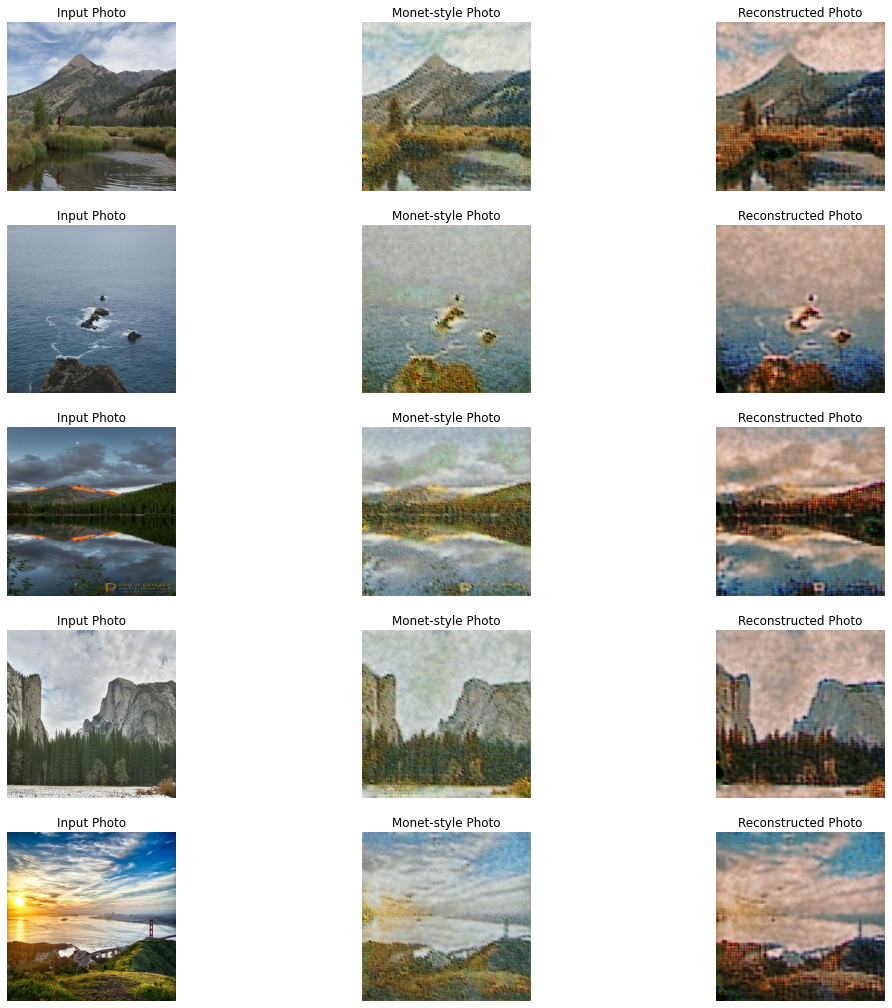

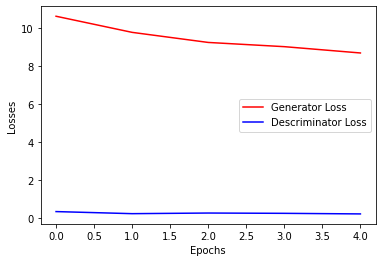

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (6/10) | Generator Loss:8.530993 | Discriminator Loss:0.253382


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (7/10) | Generator Loss:8.081239 | Discriminator Loss:0.223624


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (8/10) | Generator Loss:7.763427 | Discriminator Loss:0.199938


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (9/10) | Generator Loss:7.420443 | Discriminator Loss:0.164715


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (10/10) | Generator Loss:7.322308 | Discriminator Loss:0.140919


<Figure size 432x288 with 0 Axes>

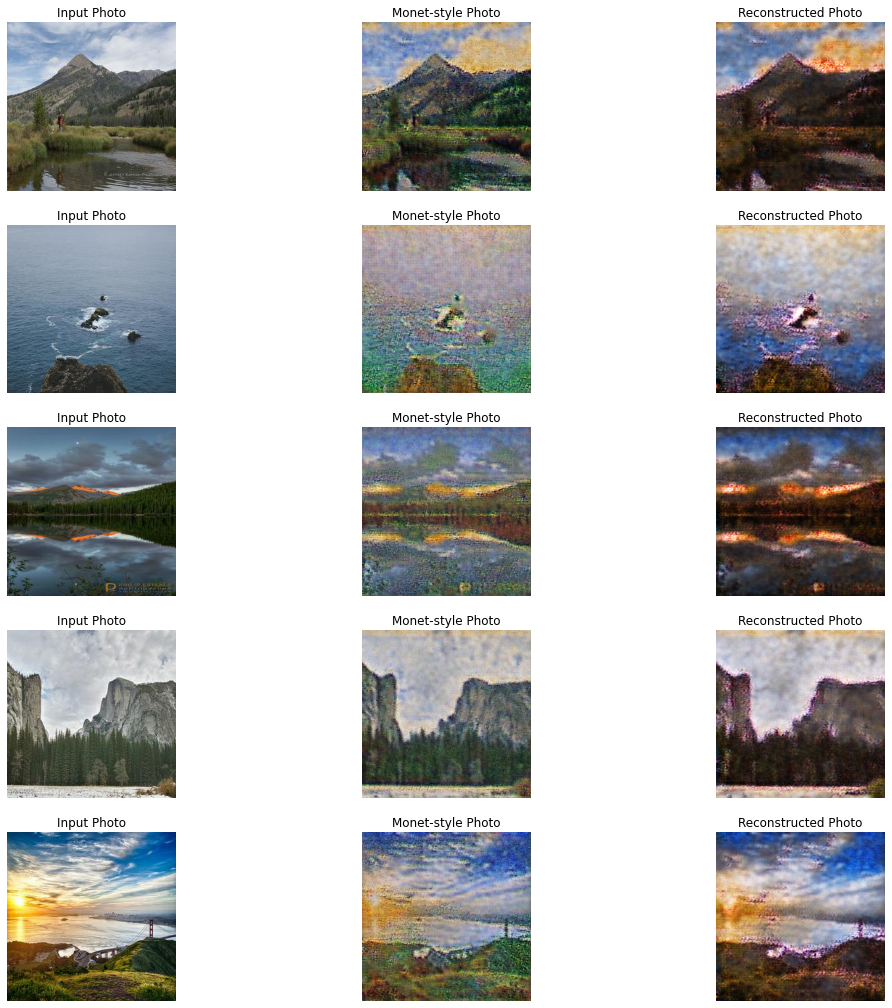

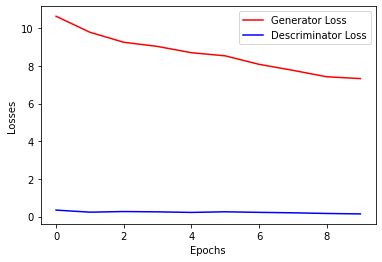

  0%|          | 0/7038 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

In [ ]:
gan = CycleGAN(device)
gan.train(img_dl)
# gan.train(img_dl, 'current.ckpt')

'''Run Generator over all images
'''
ph_ds = PhotoDataset('/content/photo_jpg/')
ph_dl = DataLoader(ph_ds, batch_size=1, pin_memory=True)

!mkdir '/content/images9a'

trans = transforms.ToPILImage()
t = tqdm(ph_dl, leave=False, total=ph_dl.__len__())
for i, (real_P, img_name) in enumerate(t):
    with torch.no_grad():
        fake_M = gan.netG_P(real_P.to(device)).cpu().detach()
    fake_M = unnorm(fake_M)
    img = trans(fake_M[0]).convert("RGB")
    img.save("/content/images9a/" + img_name[0][:-4] + "_M.jpg")

#shutil.make_archive("/content/drive/My Drive/GAN_data/images9a/", 'zip', "/content/drive/My Drive/GAN_data/")

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import shutil
import time
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import os
import glob


In [ ]:
# Constants and names
TEST_IMAGES_FOLDER = '/content/test_images/'
GENERATED_IMAGES_FOLDER = '/content/generated/'
TRAINED_WEIGHTS = 'current.ckpt'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from google.colab import files
uploaded_zip = files.upload()
uploaded_zip_name = next(iter(uploaded_zip))
uploaded_folder_name_path = '/content/' + uploaded_zip_name

Saving ezyzip.zip to ezyzip.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Check existance of folders and remove them for reuse.

tst_dir = os.path.isdir(TEST_IMAGES_FOLDER)
gen_dir = os.path.isdir(GENERATED_IMAGES_FOLDER)

if tst_dir:
  files = glob.glob(TEST_IMAGES_FOLDER+'*')
  for f in files:
    print(files)
    os.remove(f)
  
if gen_dir:
  files = glob.glob(GENERATED_IMAGES_FOLDER+'*')
  for f in files:
    os.remove(f)
  

!mkdir '/content/generated/'

In [ ]:
import zipfile
with zipfile.ZipFile(uploaded_folder_name_path, 'r') as zip_ref:
    zip_ref.extractall(TEST_IMAGES_FOLDER)

In [ ]:
# Our CycleGAN model with the predefined and redefined hyerparameters
class CycleGAN(object):
    def __init__(self, device, epochs=40):
        self.n_epochs = epochs
        self.n_epochs_decay = int(self.n_epochs/2)
        self.lambda_P = 10
        self.lambda_M = 10
        self.lambda_idt = 0.5
        self.start_lr = 2e-4
        self.device = device
        self.netG_M = Generator()
        self.netG_P = Generator()
        self.netD_M = Discriminator()
        self.netD_P = Discriminator()
        self.netG_M = self.netG_M.to(self.device)
        self.netG_P = self.netG_P.to(self.device)
        self.netD_M = self.netD_M.to(self.device)
        self.netD_P = self.netD_P.to(self.device)

        self.criterionGAN = nn.MSELoss()
        self.criterionCycle = nn.L1Loss()
        self.criterionIdt = nn.L1Loss()
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_M.parameters(), self.netG_P.parameters()),
                                         lr=self.start_lr, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_M.parameters(), self.netD_P.parameters()),
                                          lr=self.start_lr, betas=(0.5, 0.999))
        self.fake_M_pool = ImagePool()
        self.fake_P_pool = ImagePool()
        G_lr = lr_sched(self.n_epochs_decay , self.n_epochs)
        self.G_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.optimizer_G, G_lr.step)
        D_lr = lr_sched(self.n_epochs_decay , self.n_epochs)
        self.D_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.optimizer_D, D_lr.step)
        self.losses_G = []
        self.losses_D = []
        # list of 5 photos to be evaluated in epochs
        self.real_Ps = []
        # for i in range(5):
        #     real_P, _ = next(iter(img_dl))
        #     self.real_Ps.append(real_P)


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        model = list()
        model.append(nn.ReflectionPad2d(3))

        model.append(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=0, bias=True))
        model.append(nn.InstanceNorm2d(num_features=64))
        model.append(nn.ReLU())

        model.append(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True))
        model.append(nn.InstanceNorm2d(num_features=128))
        model.append(nn.ReLU())

        model.append(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=True))
        model.append(nn.InstanceNorm2d(num_features=256))
        model.append(nn.ReLU())

        for _ in range(9):      # 9 Res blocks  @@
            model.append(Resblock())

        model.append(nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1))
        model.append(nn.InstanceNorm2d(num_features=128))
        model.append(nn.Dropout(p=0.5))
        model.append(nn.ReLU())

        model.append(nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1))
        model.append(nn.InstanceNorm2d(num_features=64))
        model.append(nn.Dropout(p=0.5))
        model.append(nn.ReLU())

        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=0))
        model.append(nn.Tanh())

        self.gen = nn.Sequential(*model)

    def forward(self, x):
        return self.gen(x)

In [ ]:
class Resblock(nn.Module):
    def __init__(self):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(num_features=256))
        layers.append(nn.ReLU())

        layers.append(nn.Dropout(p=0.5))
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(num_features=256))
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)  # skip connection at end of Res block

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1))
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        model.append(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=1, padding=1, bias=True))
        model.append(nn.InstanceNorm2d(num_features=128))
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        model.append(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=1, padding=1, bias=True))
        model.append(nn.InstanceNorm2d(num_features=256))
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        model.append(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=True))
        model.append(nn.InstanceNorm2d(num_features=512))
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        model.append(nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1))
        self.disc = nn.Sequential(*model)

    def forward(self, x):
        return self.disc(x)

In [ ]:
# Save 50 generated fake images and sample through them
# to feed discriminators to avoid large oscillations 
# from iterations to iterations. (refer to CycleGAN orginal paper, section 4)
class ImagePool(object):
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        self.cur_image = 0
        self.pool = []

    def __call__(self, image):
        if self.cur_image < self.pool_size:
            self.pool.append(image)
            ret = image
            self.cur_image += 1
        else:
            if np.random.ranf() > 0.5:
                idx = np.random.randint(0, self.pool_size)
                ret = self.pool[idx]
                self.pool[idx] = image
            else:
                ret = image
        return ret

In [ ]:
# The learning rate should change in the following way: 
class lr_sched():
    def __init__(self, n_epochs_decay , n_epochs):
        self.n_epochs_decay  = n_epochs_decay 
        self.n_epochs = n_epochs

    def step(self, epoch_num):
        if epoch_num <= self.n_epochs_decay :
            return 1.0
        else:
            fract = (epoch_num - self.n_epochs_decay )  / (self.n_epochs - self.n_epochs_decay)
            return 1.0 - fract

In [ ]:
# Finally prepare the unnorm function as required in the article.
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
        
    return img

In [ ]:
!gdown https://drive.google.com/file/d/1bT0D3x1e1bFKd5uTEuLXviDOKhBViNJB

/usr/local/lib/python3.7/dist-packages/gdown/parse_url.py:39: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  url="https://drive.google.com/uc?id={}".format(file_id)
Downloading...
From: https://drive.google.com/file/d/1bT0D3x1e1bFKd5uTEuLXviDOKhBViNJB
To: /content/1bT0D3x1e1bFKd5uTEuLXviDOKhBViNJB
69.4kB [00:00, 41.4MB/s]


In [ ]:
gan = CycleGAN(device)

In [ ]:
print("=> loading trained weights '{}'".format(TRAINED_WEIGHTS))
checkpoint = torch.load(TRAINED_WEIGHTS)
epoch_count = checkpoint['epoch']
gan.netG_M.load_state_dict(checkpoint['netG_M'])
gan.netG_P.load_state_dict(checkpoint['netG_P'])
gan.netD_M.load_state_dict(checkpoint['netD_M'])
gan.netD_P.load_state_dict(checkpoint['netD_P'])
gan.optimizer_G.load_state_dict(checkpoint['optimizer_gen'])
gan.optimizer_D.load_state_dict(checkpoint['optimizer_desc'])

=> loading trained weights 'current.ckpt'


In [ ]:
class PhotoDataset(Dataset):
    def __init__(self, photo_dir):
        super().__init__()
        self.photo_dir = photo_dir
        self.photo_idx = dict()
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
        ])
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.photo_idx[idx])
        real_P = Image.open(photo_path)
        real_P = self.transform(real_P)
        return real_P, self.photo_idx[idx]

    def __len__(self):
        return len(self.photo_idx.keys())

In [ ]:
ph_ds = PhotoDataset(TEST_IMAGES_FOLDER)
ph_dl = DataLoader(ph_ds, batch_size=1, pin_memory=True)

trans = transforms.ToPILImage()
t = tqdm(ph_dl, leave=False, total=ph_dl.__len__())
for i, (real_P, img_name) in enumerate(t):
    with torch.no_grad():
        fake_M = gan.netG_P(real_P.to(device)).cpu().detach()
    fake_M = unnorm(fake_M)
    img = trans(fake_M[0]).convert("RGB")

    img.save("/content/generated/" + img_name[0][:-4] + "_M.jpg")

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Convert the directories to lists

from os import listdir
from PIL import Image as PImage

def loadImages(path):
    # return array of images

    imagesList = listdir(path)
    imagesList.sort()
    loadedImages = []
    for image in imagesList:
        img = PImage.open(path + image)
        loadedImages.append(img)

    return loadedImages

real_path = TEST_IMAGES_FOLDER
generated_path = GENERATED_IMAGES_FOLDER

# images in an array
test_imgs = loadImages(real_path)
generated_imgs = loadImages(generated_path)

Test Images vs Generated Images


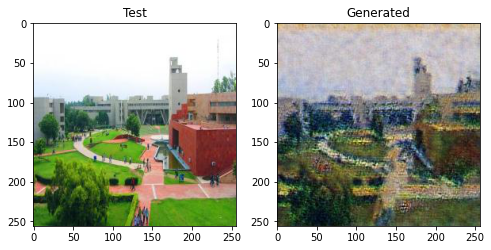

In [ ]:
# Show test images vs generated images
for i in range(len(test_imgs)):
  f = plt.figure(figsize=(8, 8))
  f.add_subplot(1, 2, 1)
  plt.title('Test')
  # original = unnorm(original)
  plt.imshow(test_imgs[i])
  f.add_subplot(1, 2, 2)
  plt.title('Generated')
  # generated = unnorm(generated)
  plt.imshow(generated_imgs[i])
print('Test Images vs Generated Images')
